# CellNet

In [1]:
IMAGES = 'all'; AUGS = 'val'
#P = 'sigma'; ps = [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
P = 'sigma'; ps = [5.0]
RELEASE = True


import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import ast
from math import prod
from types import SimpleNamespace as obj
import json

import util.data as data
import util.plot as plot


CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu'); print('device =', device)
DRAFT = False if os.getenv('BATCHED_RUN', '0')=='1' else True; print('DRAFT =', DRAFT)

def gpu(x, device=device): return torch.from_numpy(x).float().to(device)
def cpu(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.array(x) if isinstance(x, list) else x

key2text = {'tl': 'Training Loss',     'vl': 'Validation Loss', 
            'ta': 'Training Accuracy', 'va': 'Validation Accuracy', 
            'ti': 'Training Image',    'vi': 'Validation Image',
            'lf': 'Loss Function',     'lr': 'Learning Rate',
            'e' : 'Epoch',             'bs': 'Batch Size',
            'fraction': 'Fraction of Data',  'sparsity': 'Artificial Sparsity',  
            'sigma': 'Gaussian Sigma',        'maxdist': 'Max Distance',
            'rmbad': 'Prop. of Difficult Labels Removed'
            }

CROPSIZE=256


cfg_base = obj(
  epochs=(5 if CUDA else 1) if DRAFT else 101 if not RELEASE else 501,
  sigma=5.0,  # NOTE: do grid search again later when better convergence 
  maxdist=26, 
  fraction=1, 
  sparsity=1,
  lr_steps=1.25 if not RELEASE else 3.5,
  lr_gamma=0.1,
  rmbad=0,
)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


device = cuda:0
DRAFT = False


In [2]:
XNorm, _xmean, _xstd = data.mk_XNorm([1,2,4])

def mkAugs(mode):
  T = lambda ts:  A.Compose(transforms=[
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    *ts,
    XNorm(), 
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True) # type: ignore
  )

  vals = [A.D4(),
          ]

  return dict(
    test  = T([]),
    val   = T([A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
               *vals]),
    train = T([
               A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
              #A.RandomSizedCrop(p=1, min_max_height=(CROPSIZE//2, CROPSIZE*2), height=CROPSIZE, width=CROPSIZE),
              # NOTE: issue with resize is that the keypoint sizes will not be updated
               A.Rotate(),
               A.AdvancedBlur(),
               A.Equalize(),
               A.ColorJitter(), 
               A.GaussNoise(),
               *vals])
  )[mode]

batch2cpu = lambda B, z=None, y=None: [obj(**{k:cpu(v) for v,k in zip(b, 'xmklzy')}) 
              for b in zip(B['image'], B['masks'][0], B['keypoints'], B['class_labels'], 
              *([] if z is None else [z]), *([] if y is None else [y]))]

In [3]:
if DRAFT and not CUDA: 
  kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg_base)

  def plot_grid(grid, **loader_kwargs):
    loader = data.mk_loader([1], cfg=cfg_base, bs=prod(grid), **loader_kwargs)
    B = next(iter(loader))
    B = batch2cpu(B, z=kp2hm(B))
    for b,ax in zip(B, plot.grid(grid, [CROPSIZE]*2)[1]):
      plot.overlay(b.x, b.z, b.m, b.k, b.l, cfg_base.sigma, ax=ax)

  plot_grid((3,3), transforms=mkAugs('val'))
  plot_grid((3,3), transforms=mkAugs('train'))

  for B in data.mk_loader([1,2,4], cfg=cfg_base, bs=1, transforms=mkAugs('test'), shuffle=False):
    b = batch2cpu(B, z=kp2hm(B))[0]
    ax = plot.overlay(b.x, b.z, b.m, b.k, b.l, cfg_base.sigma)

In [4]:
import segmentation_models_pytorch as smp
plt.close('all')

mk_model = lambda: smp.Unet(  # NOTE TODO: check if spefically used model automatically mirror pads in training or inference
    encoder_name="resnet34" if DRAFT else "resnet152",  # 18 34 50 101 152
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
  ).to(device)  

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


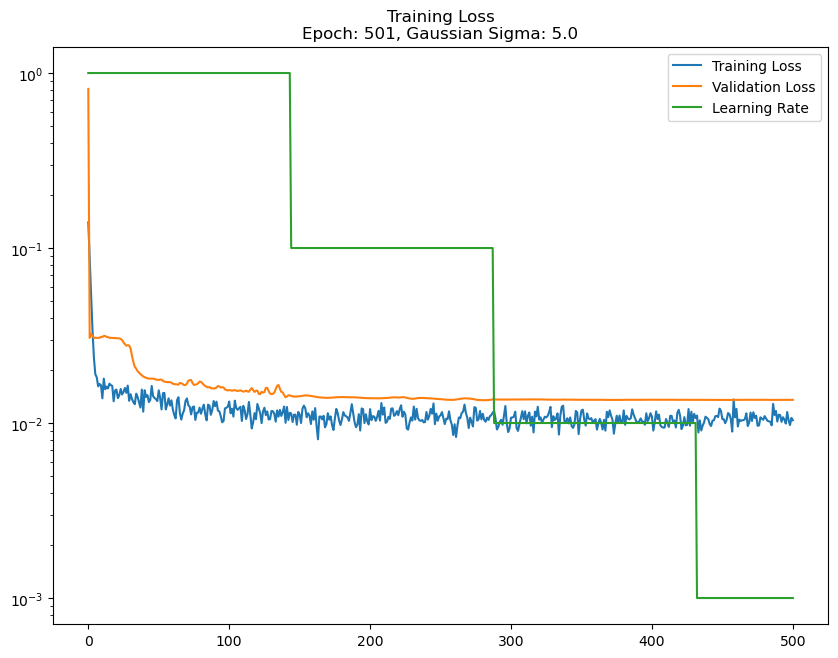

DEBUG _row:
   sigma         ti   vi        tl        vl        ta        va     lr
0    5.0  [1, 2, 4]  [1]  0.010371  0.013567  0.983059  0.936154  0.001


In [5]:

#def count(y): return yunnorm(y).sum().item()

def accuracy(y,z): 
  ny, nz = y.sum().item(), z.sum().item()
  return 1 - abs(ny - nz) / (nz+1e-9)

def train(epochs, model, optim, lossf, sched, kp2hm, traindl, valdl=None, info={}):
  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(epochs))
  def epoch(dl, train):
    l = 0; a = 0; b = 0
    for b, B in enumerate(dl):
      x,m = B['image'].to(device), B['masks'][0].to(device)
      z = kp2hm(B).to(device)

      y = model(x)
      loss = lossf(y*m, z*m) 
      l += loss.item()
      a += accuracy(y*m, z*m) # type: ignore

      if train:
        loss.backward()
        optim.step()
        optim.zero_grad()

    return l/(b+1), a/(b+1)

  for e in range(epochs):
    L = log.loc[e]
    L['lr'] = optim.param_groups[0]['lr']
  
    model.train()
    L['tl'], L['ta'] = epoch(traindl, train=True)
    sched.step() 
  
    if valdl is not None: 
      model.eval()
      with torch.no_grad():
        L['vl'], L['va'] = epoch(valdl, train=False) 

    if DRAFT: plot.train_graph(e, log, info=info, key2text=key2text, clear=True)
  plot.train_graph(epochs, log, info=info, key2text=key2text, accuracy=False) 
  return log

def loss_per_point(b, lossf, kernel=15, exclude=[]):
  loss = lossf.__class__(reduction='none')(*[torch.tensor(x) for x in [b.y, b.z]])

  p2L = np.zeros(len(b.l))
  for i, (l, (x,y)) in enumerate(zip(b.l, b.k)):
    if l in exclude: continue  # NOTE thats an ugly HACK that prevents us from getting the loss for the negative annotations
    xx, yy = np.meshgrid(np.arange(loss.shape[2]), np.arange(loss.shape[1]))
    kernel = (xx-x)**2 + (yy-y)**2 < kernel**2
    p2L[i] = (loss * kernel).sum()

  return p2L


splits = [([1], [2])] if DRAFT else\
         [([1,2,4], [1])] if RELEASE else\
         [([1], [2,4])] if IMAGES=='one' else\
         [([2,4], [1]), ([1,4], [2]), ([1,2], [4])] if IMAGES=='all' else\
         []

results = pd.DataFrame()
if not DRAFT: [os.makedirs(_p, exist_ok=True) for _p in ('preds', 'plots')]

def training_run(cfg, traindl, valdl, kp2hm, model=None):
  global results  
  p = cfg.__dict__[P]
  ti=traindl.dataset.ids; vi=valdl.dataset.ids

  if model is None: model = mk_model()
  optim = torch.optim.Adam(model.parameters(), lr=5e-3)
  lossf = torch.nn.MSELoss()
  sched = torch.optim.lr_scheduler.StepLR(optim, step_size=int(cfg.epochs/cfg.lr_steps)+1, gamma=cfg.lr_gamma)

  log = train(cfg.epochs, model, optim, lossf, sched, kp2hm, traindl, valdl, info={P: p})

  _row =  pd.DataFrame(dict(**{P: [p]}, ti=[ti], vi=[vi], **log.iloc[-1]))
  print('DEBUG _row:'); print(_row) 
  results = _row if results.empty else pd.concat([results, _row], ignore_index=True)

  i2p2L = {}
  # plot and save predictions to disk
  for ii, t in [(ti, 'T'), (vi, 'V')]:
    for i in ii:
      B = next(iter(data.mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))

      model.eval()
      with torch.no_grad(): y = cpu(model(B['image'].to(device)))
      b = batch2cpu(B, z=kp2hm(B), y=y)[0]
      del B

      if cfg.rmbad != 0: # get the badly predicted points and plot them
        p2L = loss_per_point(b, lossf, kernel=15, exclude=[2])
        if RELEASE or i in vi: 
          i2p2L[i] = p2L  # only save the losses for the validation image 
          print(f'DEBUG: saved losses for val image {i} (should happen only once per cfg and image)')

      if vi==[4] and (i in (1,4)):  # plot T1 and V4 for all [1,2]|[4] runs
        ax1 = plot.overlay(b.x, b.y, b.m, b.k, b.l, cfg.sigma) 
        ax2 = plot.diff   (b.y, b.z, b.m, b.k, b.l, cfg.sigma)

        if cfg.rmbad != 0: 
          rm = np.argsort(-p2L[i])[:int(len(B.l)*cfg.rmbad)]  # type: ignore
          [plot.points(a, b.k[rm], b.l[rm], color='#00ff00', lw=3)
            for a in (ax1, ax2)]

        if not DRAFT :  # save but don't show
          id = f"{P}={p}-{t}{i}"
          #np.save(f'preds/{id}.npy', y)
          plot.save(ax1, f'plots/{id}.pred.png')
          plot.save(ax2, f'plots/{id}.diff.png')
        if not DRAFT:
          plt.close('all')

  return dict(model=model, log=log, i2p2L=i2p2L)


loader = lambda c, ids, mode: data.mk_loader(ids, bs=1 if mode=='test' else 16, transforms=mkAugs(mode), shuffle=False, cfg=c)
if P not in ['sigma']: kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg_base)

for p in [ps[-1]] if DRAFT else ps:
  cfg = obj(**(cfg_base.__dict__ | {P: p}))
  if P in ['sigma']: kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg)

  i2p2L = {}

  for ti, vi in splits:
    cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi)))

    traindl, valdl = loader(cfg, ti, AUGS), loader(cfg, vi, 'val' if AUGS=='train' else 'test')

    out = training_run(cfg, traindl, valdl, kp2hm) # type: ignore
    i2p2L |= out['i2p2L'] # NOTE: TODO better merge with avg instead of override if image is part of multiple validation sets # type: ignore
    # NOTE TODO: the bad points are currently only removed during training with splits and not in release mode
    # -> first confirm with sfhich points are bad and then remove them in release mode

  # if rmbad is set, remove the bad points and retrain
  if cfg.rmbad != 0:
    keep = {i: np.argsort(-p2L)[int(len(p2L)*cfg.rmbad):] for i,p2L in out['i2p2L'].items()} # type: ignore
    for _i, k in keep.items(): 
      print(f"DEBUG: keeping {len(k)} of {len(out['i2p2L'][_i])} points for {_i}") # type: ignore

    for ti, vi in splits:
      cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi, epochs=cfg.epochs//2+1, rmbad=0.1)))

      traindl, valdl = loader(cfg, ti, AUGS), loader(cfg, vi, 'val' if AUGS=='train' else 'test')
      # remove the hard to predict annotations (only '1')
      for ds in [traindl.dataset, valdl.dataset]:  # NOTE: because we do it for each split repeatedly its a waste of compute. More efficient: to do it once but would need a compley refactor
        ds.P = {i: ds.P[i][keep[i]] for i in ds.P} # type: ignore
        ds.L = {i: ds.L[i][keep[i]] for i in ds.L} # type: ignore
        ds._generate_masks(fraction=1, sparsity=1) # type: ignore 
        # regenerate masks, but don't throw away more data
      
      out = training_run(cfg, traindl, valdl, kp2hm, model=out['model']) # type: ignore

In [6]:
if RELEASE: # save model to disk
  B = next(iter(data.mk_loader([1], cfg=cfg_base, bs=1, transforms=mkAugs('test'), shuffle=False)))
  x = batch2cpu(B)[0].x[None]
  
  m = out['model']
  m.eval()

  # save a test prediction to make sure the model works the same
  np.save('.cache/export_test_x_1.npy', x)
  np.save('.cache/export_test_y_1.npy', cpu(m(gpu(x))))

  m.save_pretrained('./model_export')  # specific to master branch of SMP. TODO: make more robust with onnx. But see problem notes in cellnet.yml
  os.remove('model_export/README.md')

  # save the model settings
  with open('model_export/pipeline.json', 'w') as f: json.dump(dict(xmean = _xmean, xstd = _xstd,), f, indent=2)

In [7]:

if not DRAFT:
  results.to_csv('results.csv', index=False, sep=';')
  if not RELEASE:
    R = pd.read_csv('results.csv', sep=';', converters=dict(ti=ast.literal_eval, vi=ast.literal_eval)).rename(columns=dict(vi=key2text['vi']))
    plot.regplot(R, P, key2text)

results

,sigma,ti,vi,tl,vl,ta,va,lr
0,5.0,"[1, 2, 4]",[1],0.010371,0.013567,0.983059,0.936154,0.001
